# CIFAR10 GPU/CPU/MPS PyTorch Benchmark

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time

from contextlib import suppress
# use CPU (standard)
device = torch.device("cpu")
if torch.cuda.is_available():
    # NVIDIA CUDA GPU
    device = torch.device("cuda")
else: 
    with suppress(AttributeError):
        if torch.backends.mps.is_available():
            # MacBook M1 onboard GPU
            device = torch.device("mps")
            
print("using", device, "device")

using mps device


### Load and augment CIFAR10 dataset

In [2]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# revert normalization for display
revert_norm = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])

train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
labels_map = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


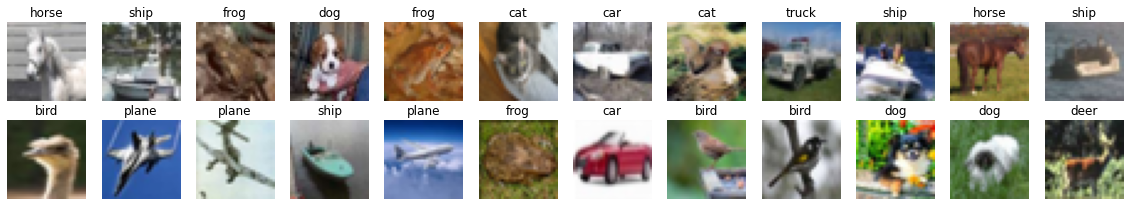

In [3]:
# display (random) subset

figure = plt.figure(figsize=(20, 3.3))
cols, rows = 12, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test), size=(1,)).item()
    img, label = test[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(revert_norm(img).squeeze().permute(1, 2, 0))
plt.show()

# Benchmark on ResNet50

## Params
Reduce batch size (BS) if the device should run out of memory. Note: high-end GPUs gain their advantage with large batch sizes.

In [4]:
BS = 1024
EPOCHS = 3

# Set device (overwrite chosen device above)
# device = torch.device("cpu")

# Load pretrained model (ImageNet) and reduce outputs to 10 for CIFAR10
# Modesl https://pytorch.org/vision/main/models.html
# For the old API, use "pretrained=True" instead of weights; or train from scratch without weights
net = models.resnet50(weights="IMAGENET1K_V1")
net.fc = torch.nn.Sequential(nn.Linear(2048,1000),nn.ReLU(),nn.Linear(1000,10))
net = net.to(device)

## Training

In [5]:
train_loader = torch.utils.data.DataLoader(train, batch_size=BS, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

total_time = 0
pbar = tqdm(range(EPOCHS))
for epoch in pbar:
    time_0 = time.time()
    losses = []
    running_loss = 0
    for i, inp in enumerate(train_loader):
        inputs, labels = inp
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        pbar.set_description(f'batch {i+1}/{len(train_loader)}; loss {running_loss/(i+1):.2f}')

    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)

    total_time += time.time() - time_0
    print(f'[{time.time() - time_0:0.5f}s] loss epoch [{epoch+1}]: {running_loss/len(train_loader):.2f}')
    running_loss = 0.0
            
print(f'Average time per epoch (batch size: {BS}, epochs: {EPOCHS}): {total_time/EPOCHS:.5f} s')

  0%|          | 0/3 [00:00<?, ?it/s]

[106.80588s] loss epoch [1]: 1.16
[110.17703s] loss epoch [2]: 0.63
[115.36520s] loss epoch [3]: 0.53
Average time per epoch (batch size: 1024, epochs: 3): 110.78270 s


## Inference (accuracy of trained net)

In [6]:
RUNS = 3

test_loader = torch.utils.data.DataLoader(test, batch_size=BS, shuffle=False)

correct = 0
total = 0
total_time = 0
pbar = tqdm(range(RUNS))
with torch.no_grad():
    for i in pbar:
        time_0 = time.time()
        for batch, data in enumerate(test_loader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_description(f'batch {batch}/{len(test_loader)}; acc. {100*(correct/total):.2f}')
        total_time += time.time() - time_0
            
print(f'Accuracy on {RUNS*10_000:,} test images: {100*(correct/total):.2f} %')
print(f'Time for {RUNS*10_000:,} images (batch size: {BS}): {total_time/RUNS:0.5f} s')

  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy on 30,000 test images: 83.39 %
Time for 30,000 images (batch size: 1024): 10.54419 s


# Notes / Sources

### Notes:
- Above performed tests continuously output data and therefore require additional resources. Furthermore, torch.cuda.synchronize() is not used under CUDA. However, the thereby created inaccuracies are far smaller than discontinuities caused by random background processes.
- Benchmarks of popular networks by the ETH Zurich https://ai-benchmark.com/ranking_deeplearning_detailed.html
- Old GPUs with low CUDA capabilities (not supported by PyTorch) are probably outperformed by todays CPUs. So don't hustle through building PyTorch from source for your old GPU. 

### Sources:
 - CIFAR10: https://www.cs.toronto.edu/~kriz/cifar.html
 - ResNet: https://arxiv.org/abs/1512.03385

### Log (time per epoch)

---
#### TRAIN (BS 128 / EPOCHS 3)
- Google Colab (CPU, 2x Xeon @2.20GHz): 1464.83851s
- Google Colab (GPU, Tesla T4): 41.03860s
- MacBook Air M1 (mps): 181.35929s (≈4.4x Tesla T4)
- MacBook Air M1 (CPU): 728.23478s (≈4.0x mps)

#### TRAIN (BS 1024 / EPOCHS 3)
- Google Colab (CPU, 2x Xeon @2.20GHz): 1343.66987s
- Google Colab (GPU, Tesla T4): 32.42535s
- MacBook Air M1 (mps): 150.28829s (≈4.6x Tesla T4)
- MacBook Air M1 (CPU): 613.62997s (≈4.1x mps)


#### INFERENCE (BS 128 / EPOCHS 3): acc. ≈67 %
- Google Colab (CPU, 2x Xeon @2.20GHz): 93.29404s
- Google Colab (GPU, Tesla T4): 4.14218s
- MacBook Air M1 (mps): 27.68964s (≈6.7x Tesla T4)
- MacBook Air M1 (CPU): 27.80319s

#### INFERENCE (BS 1024 / EPOCHS 3): acc. ≈82 %
- Google Colab (CPU, 2x Xeon @2.20GHz): 82.95507s
- Google Colab (GPU, Tesla T4): 3.05146s
- MacBook Air M1 (mps): 11.09324s (≈3.6x Tesla T4)
- MacBook Air M1 (CPU): 19.10872s

---
#### Old mobile GPU
#### TRAIN (BS 64 / EPOCHS 3)
- GT 640M LE: 1139.13198s

#### INFERENCE (BS 64 / EPOCHS 3): acc. ≈47 %
- GT 640M LE: 51.76234s

---

In [7]:
# Current CUDA GPU
!nvidia-smi

zsh:1: command not found: nvidia-smi
